# Modeling w/ additional data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


pd.options.display.max_columns = 100
pd.options.display.max_rows = 3000
pd.set_option('display.max_colwidth', -1)

<ipython-input-1-6413d9631603>:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
df_1 = pd.read_csv('../data/modeling_df.csv') # contains title and body columns
df_2 = pd.read_csv('../data/additional_data.csv') # contains text column

In [3]:
df_1.shape

(1890, 7)

In [4]:
df_2.shape

(627, 6)

In [5]:
df_1['text'] = df_1['title'] + " " + df_1['body'] 
df_1.drop(columns = {'title', 'body'},inplace = True)

In [6]:
df_1.reset_index(drop = True, inplace = True)
df_2.reset_index(drop = True, inplace = True)

In [7]:
df = pd.concat([df_1, df_2], axis = 0)
df['text'] = df['text'].astype(str)

In [8]:
df.shape

(2517, 6)

In [9]:
df.head(1)

,subreddit,body_word_count,body_character_length,title_character_length,title_upper_case_ratio,text
0,1,211,1268,128,0.054688,cmv mike bloombergs campaign is proof that the ultra wealthy in the us can afford a higher tax rate with no ill effect on them mike bloomberg recently dropped out of the 2020 presidential race after spending over 500 million dollars of his own money on his campaign even with this loss he is still worth over 55 billion dollars\n believe that this effortless spending on bloombergs part showcases the reality that is wealth inequality between the ultra rich and working class while i do not believe the rich should give up their fortunes i do believe that any arguments against taxing them more is simply propaganda from those who hold the wealth and higher power at this point media outlets claim that taxing the super wealthy is unfair and would be detrimental to those below them due to trickle down effects there is also rhetoric that many self made billionaires worked hard for their fortunes and that if we as americans work hard we might be rich ourselves one day believe that moving forward we should push for much higher taxes on those earningworth more than 1 billion usd if the money bloomberg spent on his campaign went to actual communities that need funding actual change could have been possible social programs could benefit greatly from these funds and maybe we could afford to better fund national programs such as healthcare or family leave


### Custom Stopword List

In [10]:
# Sklearn stopwords + 'cmv' & 'changemyview'
custom = ['cmv', 'changemyview', 'change', 'view', 'unpopular', 'opinion'] # my is in list of english stopwords
english_plus = text.ENGLISH_STOP_WORDS.union(custom) # English stopwords + my custom stopwords

## Modeling w/ Text and Numerical Features

In [11]:
df.head(1)


,subreddit,body_word_count,body_character_length,title_character_length,title_upper_case_ratio,text
0,1,211,1268,128,0.054688,cmv mike bloombergs campaign is proof that the ultra wealthy in the us can afford a higher tax rate with no ill effect on them mike bloomberg recently dropped out of the 2020 presidential race after spending over 500 million dollars of his own money on his campaign even with this loss he is still worth over 55 billion dollars\n believe that this effortless spending on bloombergs part showcases the reality that is wealth inequality between the ultra rich and working class while i do not believe the rich should give up their fortunes i do believe that any arguments against taxing them more is simply propaganda from those who hold the wealth and higher power at this point media outlets claim that taxing the super wealthy is unfair and would be detrimental to those below them due to trickle down effects there is also rhetoric that many self made billionaires worked hard for their fortunes and that if we as americans work hard we might be rich ourselves one day believe that moving forward we should push for much higher taxes on those earningworth more than 1 billion usd if the money bloomberg spent on his campaign went to actual communities that need funding actual change could have been possible social programs could benefit greatly from these funds and maybe we could afford to better fund national programs such as healthcare or family leave


In [12]:
#train/test/split
features = ['body_word_count', 'body_character_length', 'title_character_length', 'title_upper_case_ratio', 'text']
X = df[features]
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 39, stratify = y)


## Baseline Accuracy

In [13]:
# Baseline accuracy after stratifying data
y_train.mean(), y_test.mean()

(0.42248722316865417, 0.421957671957672)

### Applying TfidfVectorizer to Text Data

In [14]:
tvec = TfidfVectorizer(stop_words = english_plus,
                       max_df = 0.9,
                       min_df = 10,
                       ngram_range = (1,1)) 


In [15]:
# Tfidfvectorize just the text data

X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train['text']).todense(), 
                          columns=tvec.get_feature_names())

X_test_tvec = pd.DataFrame(tvec.transform(X_test['text']).todense(), 
                          columns=tvec.get_feature_names())

In [16]:
# Reset indices on all dataframes
X_train_tvec.reset_index(drop = True, inplace = True)

X_test_tvec.reset_index(drop = True, inplace = True)

X_train.reset_index(drop = True, inplace = True)

X_test.reset_index(drop = True, inplace = True)


In [17]:
# concatenate training and test datasets
combined_X_train = pd.concat([X_train_tvec, X_train], axis = 1)

combined_X_test = pd.concat([X_test_tvec, X_test], axis = 1)

In [18]:
# Drop text column
combined_X_train.drop(columns = 'text', inplace=True)
combined_X_test.drop(columns = 'text', inplace = True)

In [19]:
# Export as csv's
combined_X_train.to_csv('../data/X_train.csv', index = False )
combined_X_test.to_csv('../data/X_test.csv', index = False)
y_train.to_csv('../data/y_train.csv', index = False)
y_test.to_csv('../data/y_test.csv', index = False)

In [20]:
combined_X_test.shape, combined_X_train.shape

((756, 2628), (1761, 2628))

In [21]:
y_test.shape, y_train.shape

((756,), (1761,))

In [22]:
combined_X_train.sum().sort_values(ascending = False)

body_character_length     2.364469e+06
body_word_count           4.032570e+05
title_character_length    1.566770e+05
people                    8.329029e+01
title_upper_case_ratio    7.786226e+01
just                      6.520338e+01
like                      6.224026e+01
dont                      4.606286e+01
think                     4.382128e+01
im                        3.749757e+01
don                       3.483036e+01
time                      3.366660e+01
want                      3.251452e+01
know                      3.236730e+01
good                      3.214873e+01
way                       3.165541e+01
feel                      3.130092e+01
make                      3.120709e+01
really                    3.058153e+01
say                       2.858332e+01
better                    2.831284e+01
things                    2.763330e+01
person                    2.665112e+01
life                      2.566661e+01
work                      2.408278e+01
lot                      

In [23]:
combined_X_test.sum().sort_values(ascending = False)

body_character_length     1.044302e+06
body_word_count           1.781600e+05
title_character_length    6.783800e+04
people                    3.958822e+01
title_upper_case_ratio    3.347817e+01
just                      2.814554e+01
like                      2.638194e+01
dont                      2.104061e+01
think                     1.951815e+01
im                        1.744664e+01
time                      1.648415e+01
want                      1.614589e+01
know                      1.605682e+01
way                       1.458113e+01
really                    1.371618e+01
don                       1.347561e+01
make                      1.296044e+01
good                      1.293603e+01
feel                      1.187083e+01
say                       1.160532e+01
women                     1.145778e+01
need                      1.087033e+01
lot                       1.084651e+01
believe                   1.072839e+01
point                     1.059687e+01
things                   

### Logistic Regression w/ GridSearchCV

#### Pipe 1

In [24]:
pipe_lr = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression())    
])

In [25]:
pipe_lr_params = {'ss__with_mean': [True, False],
                  'ss__with_std' : [True, False],
                  'lr__penalty' : ['l2'],                       
                  'lr__C' :[1, 0.1, 0.001, 10],
                  'lr__solver': ['lbfgs', 'newton-cg'],
                  'lr__max_iter': [1000, 2000, 3000]
                 
                 }

In [26]:
# Instantiate our GridSearchCV object.
pipe_lr_gridsearch = GridSearchCV(pipe_lr, 
                                 pipe_lr_params, 
                                 cv = 5, 
                                 verbose=1)


In [27]:
pipe_lr_gridsearch.fit(combined_X_train, y_train)


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 10.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [1, 0.1, 0.001, 10],
                         'lr__max_iter': [1000, 2000, 3000],
                         'lr__penalty': ['l2'],
                         'lr__solver': ['lbfgs', 'newton-cg'],
                         'ss__with_mean': [True, False],
                         'ss__with_std': [True, False]},
             verbose=1)

In [28]:
pipe_lr_gridsearch.best_score_


0.8506406129281483

In [29]:
pipe_lr_gridsearch.best_params_


{'lr__C': 10,
 'lr__max_iter': 1000,
 'lr__penalty': 'l2',
 'lr__solver': 'lbfgs',
 'ss__with_mean': True,
 'ss__with_std': False}

In [30]:
pipe_lr_gridsearch.score(combined_X_test, y_test)

0.8518518518518519

In [31]:
pipe_lr_gridsearch.best_estimator_

Pipeline(steps=[('ss', StandardScaler(with_std=False)),
                ('lr', LogisticRegression(C=10, max_iter=1000))])

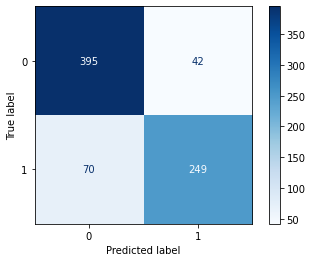

In [32]:
# Get predictions
preds = pipe_lr_gridsearch.predict(combined_X_test)

# View confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(pipe_lr_gridsearch, combined_X_test, y_test, cmap='Blues', values_format='d');


In [33]:
# Calculate the specificity
tn / (tn + fp)


0.9038901601830663

#### Pipe 2

In [34]:
pipe_lr2 = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression())    
])

In [35]:
pipe_lr2_params = {'ss__with_mean': [True, False],
                  'ss__with_std' : [True, False],
                  'lr__penalty' : ['l1'],
                  'lr__C' :[1, 0.1, 0.001, 10],
                  'lr__solver': ['liblinear'],
                  'lr__max_iter': [1000, 2000, 3000]
                 
                 }

In [36]:
# Instantiate our GridSearchCV object.
pipe_lr2_gridsearch = GridSearchCV(pipe_lr2, 
                                 pipe_lr2_params, 
                                 cv=5, 
                                 verbose=1)

In [37]:
pipe_lr2_gridsearch.fit(combined_X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  5.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [1, 0.1, 0.001, 10],
                         'lr__max_iter': [1000, 2000, 3000],
                         'lr__penalty': ['l1'], 'lr__solver': ['liblinear'],
                         'ss__with_mean': [True, False],
                         'ss__with_std': [True, False]},
             verbose=1)

In [38]:
pipe_lr2_gridsearch.best_score_

0.8398532062838011

In [39]:
pipe_lr2_gridsearch.best_params_

{'lr__C': 0.1,
 'lr__max_iter': 1000,
 'lr__penalty': 'l1',
 'lr__solver': 'liblinear',
 'ss__with_mean': False,
 'ss__with_std': True}

In [40]:
pipe_lr2_gridsearch.score(combined_X_test, y_test)

0.8452380952380952

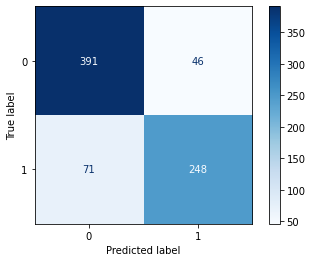

In [41]:
# Get predictions
preds = pipe_lr2_gridsearch.predict(combined_X_test)

# View confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(pipe_lr2_gridsearch, combined_X_test, y_test, cmap='Blues', values_format='d');

In [42]:
# Calculate the specificity
tn / (tn + fp)


0.8947368421052632

### RandomForest & ExtraTrees

In [43]:
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
cross_val_score(rf, combined_X_train, y_train).mean(), cross_val_score(et, combined_X_train, y_train).mean()

(0.894921774401236, 0.8540464846767962)

In [44]:
#Will stick with RandomForest
params = {
    'n_estimators': [75, 100, 125],
    'max_depth' : [None, 3, 4],
    'max_features': ['auto', None]
}
gs = GridSearchCV(rf, param_grid = params)
gs.fit(combined_X_train, y_train)


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 3, 4],
                         'max_features': ['auto', None],
                         'n_estimators': [75, 100, 125]})

In [45]:
gs.best_score_


0.9159557687355138

In [46]:
gs.best_params_


{'max_depth': None, 'max_features': None, 'n_estimators': 100}

In [47]:
gs.score(combined_X_test, y_test)


0.9246031746031746

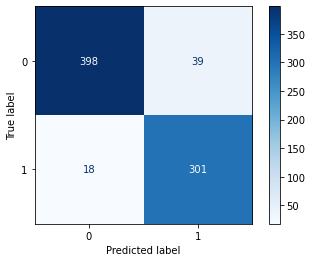

In [48]:
# Get predictions
preds = gs.predict(combined_X_test)

# View confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(gs, combined_X_test, y_test, cmap='Blues', values_format='d');


In [49]:
# Calculate the specificity
tn / (tn + fp)


0.9107551487414187